# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самыми высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats as st
import seaborn as sns

Загрузим данные.

In [2]:
try:
    df_1 = pd.read_csv('')
    df_2 = pd.read_csv('')
    df_3 = pd.read_csv('')
except:
    df_1 = pd.read_csv('')
    df_2 = pd.read_csv('')
    df_3 = pd.read_csv('')

Для избежания повторения кода добавим данные по регионам в словарь. 

In [3]:
data = []
data.append(df_1)
data.append(df_2)
data.append(df_3)

### Ознакомление с данными

Ознакомимся с данными. Рассмотрим первые строки полученных датасетов.

In [4]:
for i in range(3):
    display(data[i].head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные сформировались корректно. Рассмотрим основную информацию о данных.

In [5]:
for i in range(3):
    data[i].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Проблем с пропусками данных не наблюдается.

### Дубликаты

Рассмотрим явные дубликаты.

In [6]:
for i in range(3):
    display(data[i].duplicated().sum())

0

0

0

Явные полные дубликаты отсутствуют.

Рассмотрим явные дубликаты по столбцу `id`.

In [7]:
for i in range(3):
    display(data[i]['id'].duplicated().sum())
    display(data[i].shape)

10

(100000, 5)

4

(100000, 5)

4

(100000, 5)

В данных имеются дубликаты по столбцу `id`, их количество не сопоставимо мало по сравнению с общим количеством строк в данных. Удалим их.

In [8]:
for i in range(3):
    data[i] = data[i].drop_duplicates(subset='id')
    display(data[i]['id'].duplicated().sum())
    display(data[i].shape)

0

(99990, 5)

0

(99996, 5)

0

(99996, 5)

Рассмотрим неявные дубликаты в столбце `id`.

In [9]:
for i in range(3):
    data[i]['id'] = data[i]['id'].str.lower()
    display(data[i]['id'].duplicated().sum())

/tmp/ipykernel_457/769167322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]['id'] = data[i]['id'].str.lower()


103

109

95

Имеются неявные дубликаты в столбце `id`. Количество дубликатов так же очень мало. Удалим их.

In [10]:
for i in range(3):
    data[i] = data[i].drop_duplicates(subset='id')
    display(data[i]['id'].str.lower().duplicated().sum())
    display(data[i].shape)

0

(99887, 5)

0

(99887, 5)

0

(99901, 5)

### Рассмотрим распределения признаков и целевой переменной для каждого региона.

#### Регион №1

Рассмотрим распределение значений признака f0.

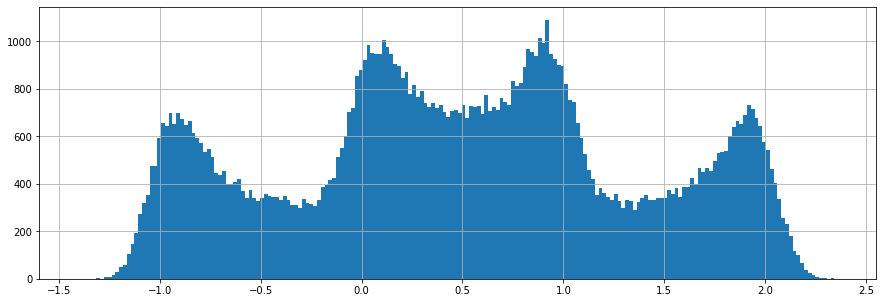

In [11]:
data[0]['f0'].hist(bins=200, figsize=(15,5));

Значения признака f0 распределены симметрично относительно оси 0.5. Выбросов и редких значений не наблюдается.

Рассмотрим распределение значений признака f1.

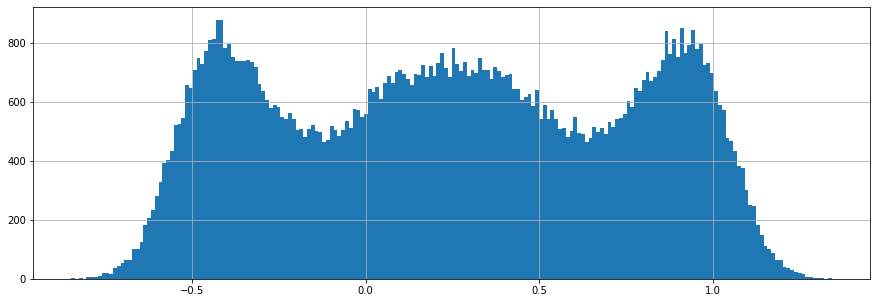

In [12]:
data[0]['f1'].hist(bins=200, figsize=(15,5));

Рассмотрим распределение значений признака f2.

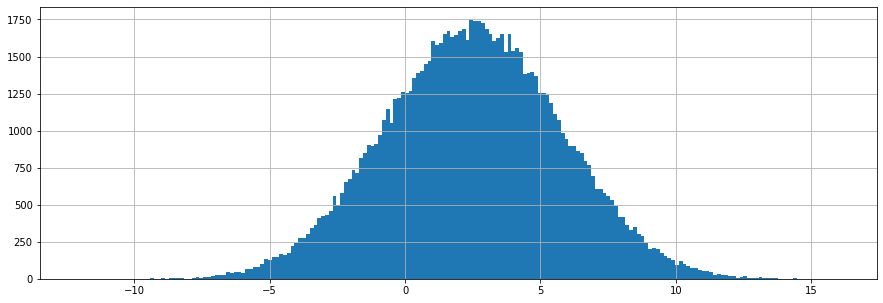

In [13]:
data[0]['f2'].hist(bins=200, figsize=(15,5));

Значения признака f2 распределены нормально.

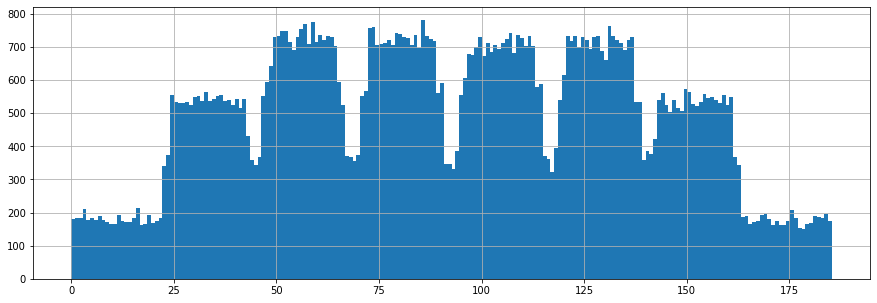

In [14]:
data[0]['product'].hist(bins=200, figsize=(15,5));

#### Регион №2

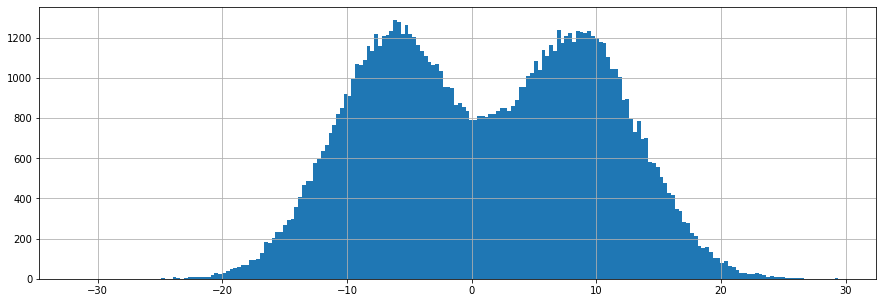

In [15]:
data[1]['f0'].hist(bins=200, figsize=(15,5));

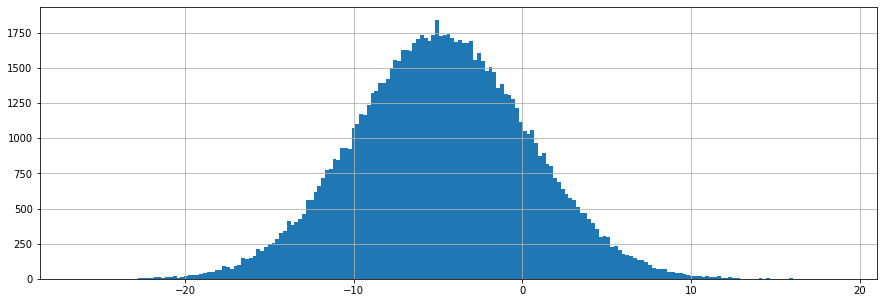

In [16]:
data[1]['f1'].hist(bins=200, figsize=(15,5));

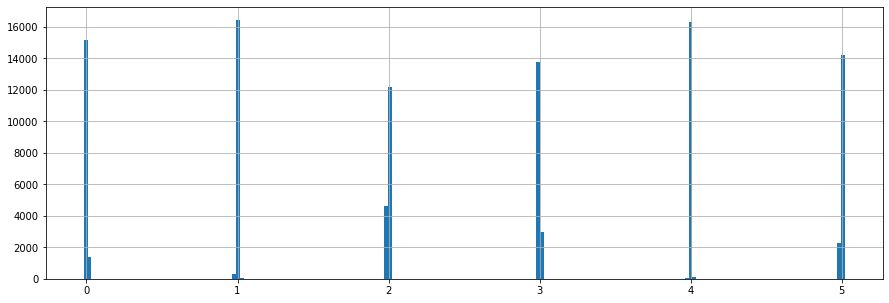

In [17]:
data[1]['f2'].hist(bins=200, figsize=(15,5));

Значения признака f2 для региона №2 распределены дискретно.

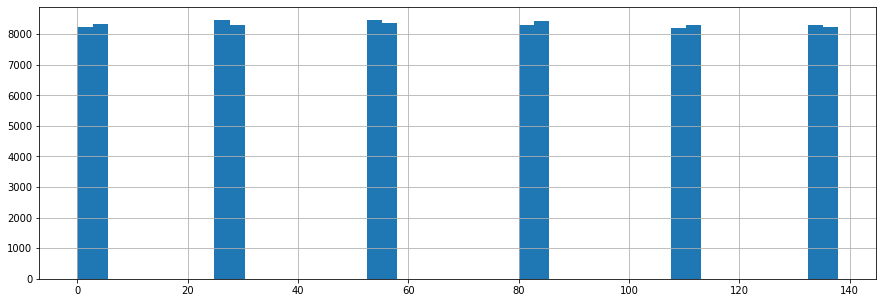

In [18]:
data[1]['product'].hist(bins=50, figsize=(15,5));

Значения целевой переменной для региона №2 распределены дискретно.

#### Регион №3

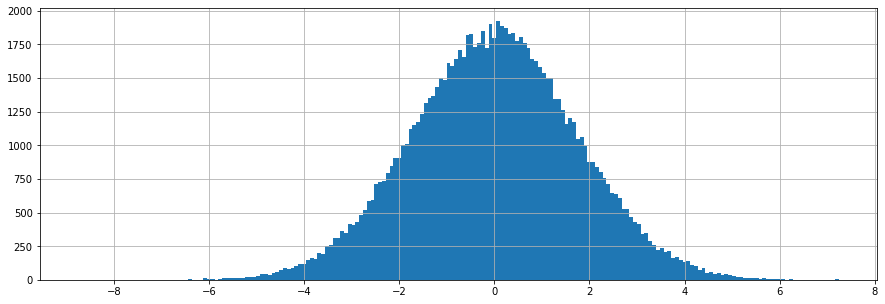

In [19]:
data[2]['f0'].hist(bins=200, figsize=(15,5));

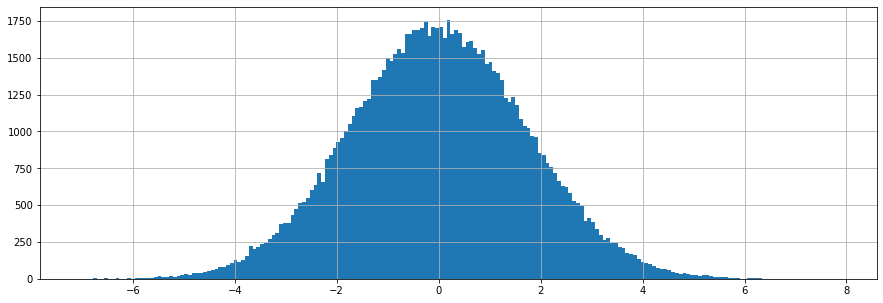

In [20]:
data[2]['f1'].hist(bins=200, figsize=(15,5));

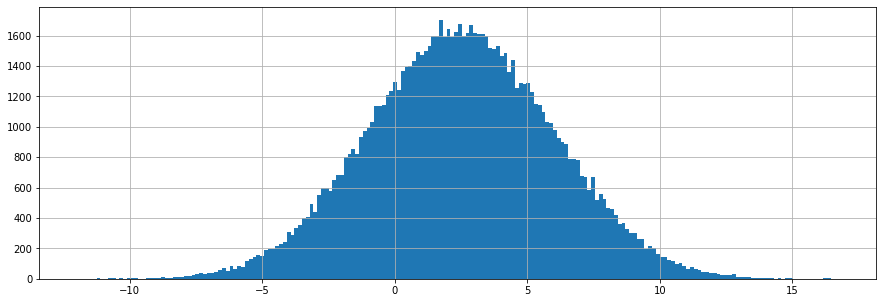

In [21]:
data[2]['f2'].hist(bins=200, figsize=(15,5));

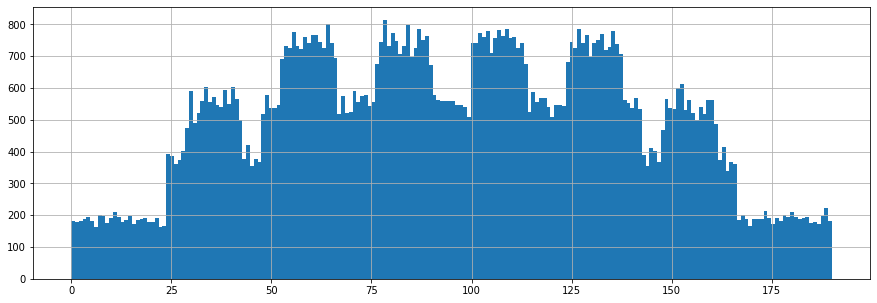

In [22]:
data[2]['product'].hist(bins=200, figsize=(15,5));

#### Оценим мультиколлинеарность

Для оценки мультиколлинеарности построим тепловую карту корреляции.

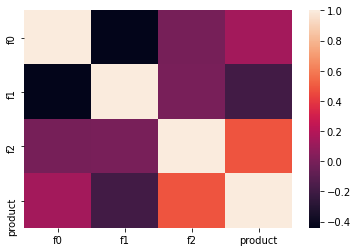

In [23]:
sns.heatmap(data[0].corr());

Для региона №1 наблюдается слабая зависимость целевой переменной от признаков, наибольшая зависимость от признака f2. Так же наблюдаются зависимости признаков друг от друга. Минимальная зависимость у признака f1 от f0.

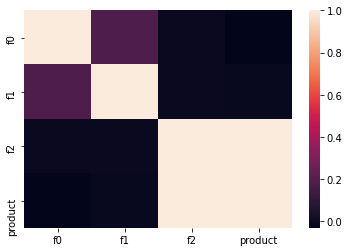

In [24]:
sns.heatmap(data[1].corr());

Для региона №2 наблюдается сильная зависимость целевой переменной от признака f2. Высокий коэффициент корреляции признака и целевой переменной в пользу точности предсказаний. Слабая корреляция присутствует и между признаками f1 и f0.

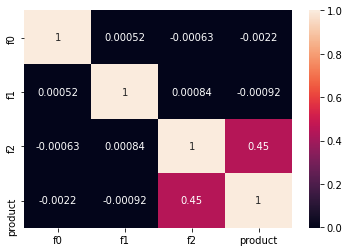

In [35]:
sns.heatmap(data[2].corr(), annot=True);

Для региона №3 наблюдается корреляция значения целевой переменной с признаком f2.

Подготовим данные к моделированию.

Напишем функцию для разделения данных на обучающую и валидационную выборки в соотношении 75% к 25% соответственно.

In [26]:
def split(data):
    df_train, df_valid = train_test_split(data, test_size=.25, random_state=765)
    print('Доля обучающей выборки равна', round(df_train.shape[0] / data.shape[0] * 100, 2), '% от исходных')
    print('Доля валидационной выборки равна', round(df_valid.shape[0] / data.shape[0] * 100, 2), '% от исходных')
    return df_train, df_valid


## Обучение и проверка модели

Напишем функцию для выделения признаков, обучения модели, вывода RMSE модели и предсказанного среднего запаса сырья. Функция будет возвращать целевой признак и предсказания модели.

In [27]:
def modeling(data):
    df_train, df_valid = split(data)
    features_train = df_train.drop(['id', 'product'], axis=1)
    target_train = df_train['product']
    features_valid = df_valid.drop(['id', 'product'], axis=1)
    target_valid = df_valid['product']

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = pd.Series(model.predict(features_valid), index=target_valid.index)
    result = mean_squared_error(target_valid, predictions_valid)**.5
    product_mean = predictions_valid.mean()
    print('RMSE модели для региона равна', result)
    print('Средний запас предсказанного сырья равен', product_mean)
    print('Средний реальный запас сырья равен', target_valid.mean())
    return target_valid, predictions_valid

В цикле применим полученную выше функцию к данным по регионам. Добавим целевой признак и результаты моделирования по каждому региону в словарь.

In [28]:
models_target_predict = []
for i in range(0, 3):
    model_predict = []
    print('Регион', i + 1)    
    target_valid, predictions_valid = modeling(data[i])
    model_predict.append(target_valid)
    model_predict.append(predictions_valid)
    models_target_predict.append(model_predict)
    print('--------------------------------------')

Регион 1
Доля обучающей выборки равна 75.0 % от исходных
Доля валидационной выборки равна 25.0 % от исходных
RMSE модели для региона равна 37.55804805426385
Средний запас предсказанного сырья равен 92.4157269749441
Средний реальный запас сырья равен 92.38721610331712
--------------------------------------
Регион 2
Доля обучающей выборки равна 75.0 % от исходных
Доля валидационной выборки равна 25.0 % от исходных
RMSE модели для региона равна 0.8921482247280595
Средний запас предсказанного сырья равен 68.74973577556894
Средний реальный запас сырья равен 68.74648542305144
--------------------------------------
Регион 3
Доля обучающей выборки равна 75.0 % от исходных
Доля валидационной выборки равна 25.0 % от исходных
RMSE модели для региона равна 40.27291660376612
Средний запас предсказанного сырья равен 95.17509926339136
Средний реальный запас сырья равен 95.18715007522695
--------------------------------------


Модели обучены. Минимальное значение RMSE у результатов работы модели над данными региона №2. Так как средний запас в каждом регионе ниже объема безубыточности, то качество предсказания имеет огромное значение - важно определить скважины с максимальным запасом. 

## Подготовка к расчёту прибыли

Введем переменные необходимые для дальнейших расчетов.

In [29]:
BUDGET_ALL = 10e9
FIELDS_COUNT = 200
PRICE_PER_KBARR = 450e3

Рассчитаем минимальное среднее значение запасов скважины для безубыточной разработки.

In [30]:
loss_free_debt = BUDGET_ALL / FIELDS_COUNT / PRICE_PER_KBARR
loss_free_debt

111.11111111111111

Минимальное среднее значение для безубыточной разработки выше средних значений предсказанных моделью запасов по всем регионам.

## Расчёт прибыли и рисков 

Напишем функцию для сортировки, выбора максимальных предсказанных значений и подсчета прибыли от выбранных месторождений.

In [31]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRICE_PER_KBARR * selected.sum() - BUDGET_ALL

В цикле применим бутстреп к результатам моделирования по каждому региону. Выберем 500 месторождений, из них выберем 200 с максимальными значениями предсказаний. Для полученных месторождений посчитаем прибыль по целевому признаку. Добавим полученные данные по каждому региону в словарь.

In [32]:
state = np.random.RandomState(765)
values_for_regions = []
for n in range(3):
    values = []
    for i in range(1000):
        target_subsample = models_target_predict[n][0].sample(n=500, replace=True, random_state=state)
        probs_subsample = models_target_predict[n][1][target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, FIELDS_COUNT) / 1e6)
    values = pd.Series(values)
    values_for_regions.append(values)

Выведем 95%й доверительный интервал и среднее значение прибыли по региону.

In [33]:
for i in range(3):
    print('Регион', i + 1)
    print(
        '95%й доверительный интервал:', 
        values_for_regions[i].quantile(.025), values_for_regions[i].quantile(.975),
        'млн.'
    )
    print('Среднее значение по региону:', values_for_regions[i].mean(), 'млн.')
    print('--------------------------------------------------------')

Регион 1
95%й доверительный интервал: -53.41488531377349 991.8611602811426 млн.
Среднее значение по региону: 499.31734358017553 млн.
--------------------------------------------------------
Регион 2
95%й доверительный интервал: 75.29846813486739 955.0529082043249 млн.
Среднее значение по региону: 502.47547743775556 млн.
--------------------------------------------------------
Регион 3
95%й доверительный интервал: -86.0814924086608 913.5793971280327 млн.
Среднее значение по региону: 416.53195786600736 млн.
--------------------------------------------------------


Оценим риск убытков. Выведем долю убыточных вариантов выбора месторождений среди общего количества вариантов.

In [34]:
for i in range(3):
    print('Доля убыточных вариантов для месторождения №', i + 1,
          'составляет',
          round(values_for_regions[i].loc[values_for_regions[i] < 0].count() / values_for_regions[i].count() * 100, 1), 
          '%'
         )

Доля убыточных вариантов для месторождения № 1 составляет 3.7 %
Доля убыточных вариантов для месторождения № 2 составляет 0.9 %
Доля убыточных вариантов для месторождения № 3 составляет 5.5 %


Для региона №2 вероятность выбрать убыточный вариант подбора 500 месторождений минимальна. Среднее значение прибыли для региона №2 так же больше чем удругих регионов. Для разработки можно порекомендовать регион №2.